# Daily Demand Forecasting
The data set used for this project is a collection of data over 60 days from a Brazilian logistics company. It's a time-series data set with 60 observations and 12 features. The target value/value to predict is the total number of orders daily. I will use regression learning to analyze and create predictions for this dataset.  Below are the variables in the data set and descriptions of what they are. The data set can be found here: https://archive.ics.uci.edu/dataset/409/daily+demand+forecasting+orders

|Variable |	Description|
|:---------|:-------------|
| Week of the month (1st to 5th) | The numbered week of the month |
| Day of the week ( M to F) | Specific Day of Week |
| Non-urgent order | Whether the order was designated non-urgent |
| Urgent order | Whether the order was designated as urgent |
| Order Type A | If it was a Type A order |
| Order Type B | If it was a Type B order |
| Order Type C | If it was a Type C order |
| Fiscal sector orders | Orders originating from the fiscal sector |
| Orders from the traffic controller sector | Orders originanting from traffic controller sector |
| Banking orders (1) | Type of banking orders |
| Banking orders (2) | 2nd type of banking orders |
| Banking orders (3) | 3rd type of banking orders |
| Total orders | Total number of orders|




The first step is to import the necessary libraries. 

In [253]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

# Data Import
Now import and inspect the data:

In [254]:
df = pd.read_csv('Daily_Demand_Forecasting_Orders.csv')
df.head()

,Week of the month (first week,second,third,fourth or fifth week;Day of the week (Monday to Friday);Non-urgent order;Urgent order;Order type A;Order type B;Order type C;Fiscal sector orders;Orders from the traffic controller sector;Banking orders (1);Banking orders (2);Banking orders (3);Target (Total orders)
0,1;4;316.307;223.270;61.543;175.586;302.448;0;6...,NaN,NaN,NaN
1,1;5;128.633;96.042;38.058;56.037;130.580;0;404...,NaN,NaN,NaN
2,1;6;43.651;84.375;21.826;25.125;82.461;1.386;1...,NaN,NaN,NaN
3,2;2;171.297;127.667;41.542;113.294;162.284;18....,NaN,NaN,NaN
4,2;3;90.532;113.526;37.679;56.618;116.220;6.459...,NaN,NaN,NaN


# Data Cleaning
It's clear from the df.head() result that the data is not exactly in the format to be expected for a csv file, which assumes a comma as a separator. So we know at least some sort of cleaning has to be done. 

In [255]:
df = pd.read_csv('Daily_Demand_Forecasting_Orders.csv', sep=';')
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In the above, there appears to be a day of week labeled '6', which doesn't make sense based on the desciption that was provided: I would expect to see values from 1-5 that correspond to Mon-Fri. So further investigation was warranted. 


In [256]:
print(df.groupby('Day of the week (Monday to Friday)')['Target (Total orders)'].count())

Day of the week (Monday to Friday)
2    11
3    12
4    13
5    12
6    12
Name: Target (Total orders), dtype: int64


The above shows that they start the week count with Sunday = 1, so 2-6 corresponds to Mon-Fri. 

However, when inspecting the order numbers, there appears to be issues with the order counts related to the sectors (i.e. Banking orders 1-3 and Orders from the traffic controller sector). For example, line 1 in the df.head() print out above is showing 65,556 orders from the traffic controller sector alone for Wednesday (Day 4) of the first week of the month, compared to 539.577 total orders - which can't be accurate. Researching this data set led me to discover that the order counts for the afore-mentioned sector columns were all off by a factor of 1,000 - so all needed to be cleaned. 

In [257]:
# clean up the necessary columns
df['Orders from the traffic controller sector'] = df['Orders from the traffic controller sector']/1000
df['Banking orders (1)'] = df['Banking orders (1)']/1000
df['Banking orders (2)'] = df['Banking orders (2)']/1000
df['Banking orders (3)'] = df['Banking orders (3)']/1000
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65.556,44.914,188.411,14.793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40.419,21.399,89.461,7.679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11.992,3.452,21.305,14.947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49.971,33.703,69.054,18.423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48.534,19.646,16.411,20.257,210.517


The values for the applicable order sectors are now cleaned up and ready to use, so I inspected the data to ensure there were no missing/NaN values. 



In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 1   Day of the week (Monday to Friday)                                  60 non-null     int64  
 2   Non-urgent order                                                    60 non-null     float64
 3   Urgent order                                                        60 non-null     float64
 4   Order type A                                                        60 non-null     float64
 5   Order type B                                                        60 non-null     float64
 6   Order type C                                                        60 non-null     float64
 7   Fiscal sector order

Later in the analysis I started having issues with the column names and values due to how they are formatted - there were patsy errors being generated by patsy when creating an OLS model - after a lot of testing it turns out I could fix the errors by duplicating each of the columns - I also created new names that are more appropriate for python, and then dropped the original columns. 

In [259]:
df['week_of_month'] = df['Week of the month (first week, second, third, fourth or fifth week'] * 1
df['day_of_week'] = df['Day of the week (Monday to Friday)'] * 1
df['non_urgent_order'] = df['Non-urgent order'] * 1
df['urgent_order'] = df['Urgent order'] * 1
df['order_type_a'] = df['Order type A'] * 1
df['order_type_b'] = df['Order type B'] * 1
df['order_type_c'] = df['Order type C'] * 1
df['fiscal_sector_orders'] = df['Fiscal sector orders'] * 1
df['traffic_sector_orders'] = df['Orders from the traffic controller sector'] * 1
df['banking_orders_1'] = df['Banking orders (1)'] * 1
df['banking_orders_2'] = df['Banking orders (2)'] * 1
df['banking_orders_3'] = df['Banking orders (3)'] * 1
df['total_orders'] = df['Target (Total orders)'] * 1

df = df.drop(df.columns[:13], axis=1)

df.head()

,week_of_month,day_of_week,non_urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,traffic_sector_orders,banking_orders_1,banking_orders_2,banking_orders_3,total_orders
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65.556,44.914,188.411,14.793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40.419,21.399,89.461,7.679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11.992,3.452,21.305,14.947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49.971,33.703,69.054,18.423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48.534,19.646,16.411,20.257,210.517


# EDA

I would have intuitively expected the week of the month to be highly correlated with the total orderse variable, assuming many companies wait until late in the month to replenish stock for the next month. I also anticipated week of the month and urgent orders to be two highly correlated features for the same reason, with companies utilizing 'just-in-time' delivery. However, that proved not to be the case; apparently the orders are more evenly spread across months than I anticipated. 

The table at the beginning of this notebook describes the features used, and the info output shows the types, all of which seem to be correct.  

My first exploratory data analysis step was to review the correlation matrix to give me an idea of which features may be the best predictors and also what features may be highlighy correlated with one another and display evidence of multi-collinearity.

In [262]:
df.corr()

,week_of_month,day_of_week,non_urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,traffic_sector_orders,banking_orders_1,banking_orders_2,banking_orders_3,total_orders
week_of_month,1.000000,-0.207791,0.243472,0.118258,0.256115,0.312767,-0.041582,0.000964,-0.194088,0.392310,0.147086,-0.157059,0.211709
day_of_week,-0.207791,1.000000,-0.416331,-0.517106,-0.068894,-0.376512,-0.448823,-0.132397,-0.339485,-0.051815,-0.577035,-0.012251,-0.435286
non_urgent_order,0.243472,-0.416331,1.000000,0.564796,0.561397,0.827186,0.752627,-0.057150,0.246937,0.732357,0.788192,0.132857,0.934518
urgent_order,0.118258,-0.517106,0.564796,1.000000,0.412817,0.508929,0.767155,-0.011452,0.242268,0.230618,0.660868,0.031260,0.729785
order_type_a,0.256115,-0.068894,0.561397,0.412817,1.000000,0.438734,0.218651,0.064525,-0.151762,0.675328,0.294374,0.230369,0.559735
order_type_b,0.312767,-0.376512,0.827186,0.508929,0.438734,1.000000,0.523598,-0.122432,0.127111,0.592845,0.713674,0.067325,0.900673
order_type_c,-0.041582,-0.448823,0.752627,0.767155,0.218651,0.523598,1.000000,0.007906,0.442404,0.330186,0.718739,0.031053,0.804984
fiscal_sector_orders,0.000964,-0.132397,-0.057150,-0.011452,0.064525,-0.122432,0.007906,1.000000,0.197670,0.003523,-0.055066,0.294567,-0.052116
traffic_sector_orders,-0.194088,-0.339485,0.246937,0.242268,-0.151762,0.127111,0.442404,0.197670,1.000000,-0.162309,0.240450,0.231614,0.244712
banking_orders_1,0.392310,-0.051815,0.732357,0.230618,0.675328,0.592845,0.330186,0.003523,-0.162309,1.000000,0.262905,0.221335,0.630365


It's useful to view a heatmap as well, so we'll create that for the correlation. 

<Axes: >

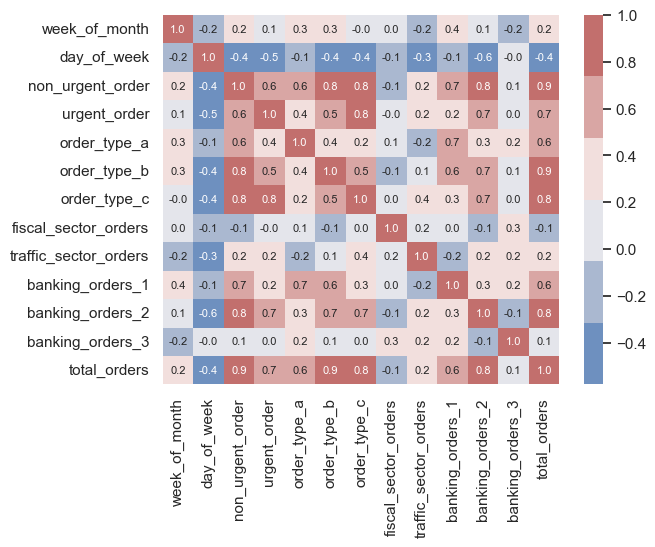

In [263]:
# create a heatmap of the above. 
sns.heatmap(df.corr(), cmap=sns.color_palette("vlag"),
            annot=True, annot_kws={'size':8}, fmt=".1f")

The correlation matrix and pair-plot (below) show that the features non-urgent_order, order_type_b, order_type_c, and banking_orders_2 are the most highly positively correlated with the target variable, total_orders. Day of the week has a negative correlation. 

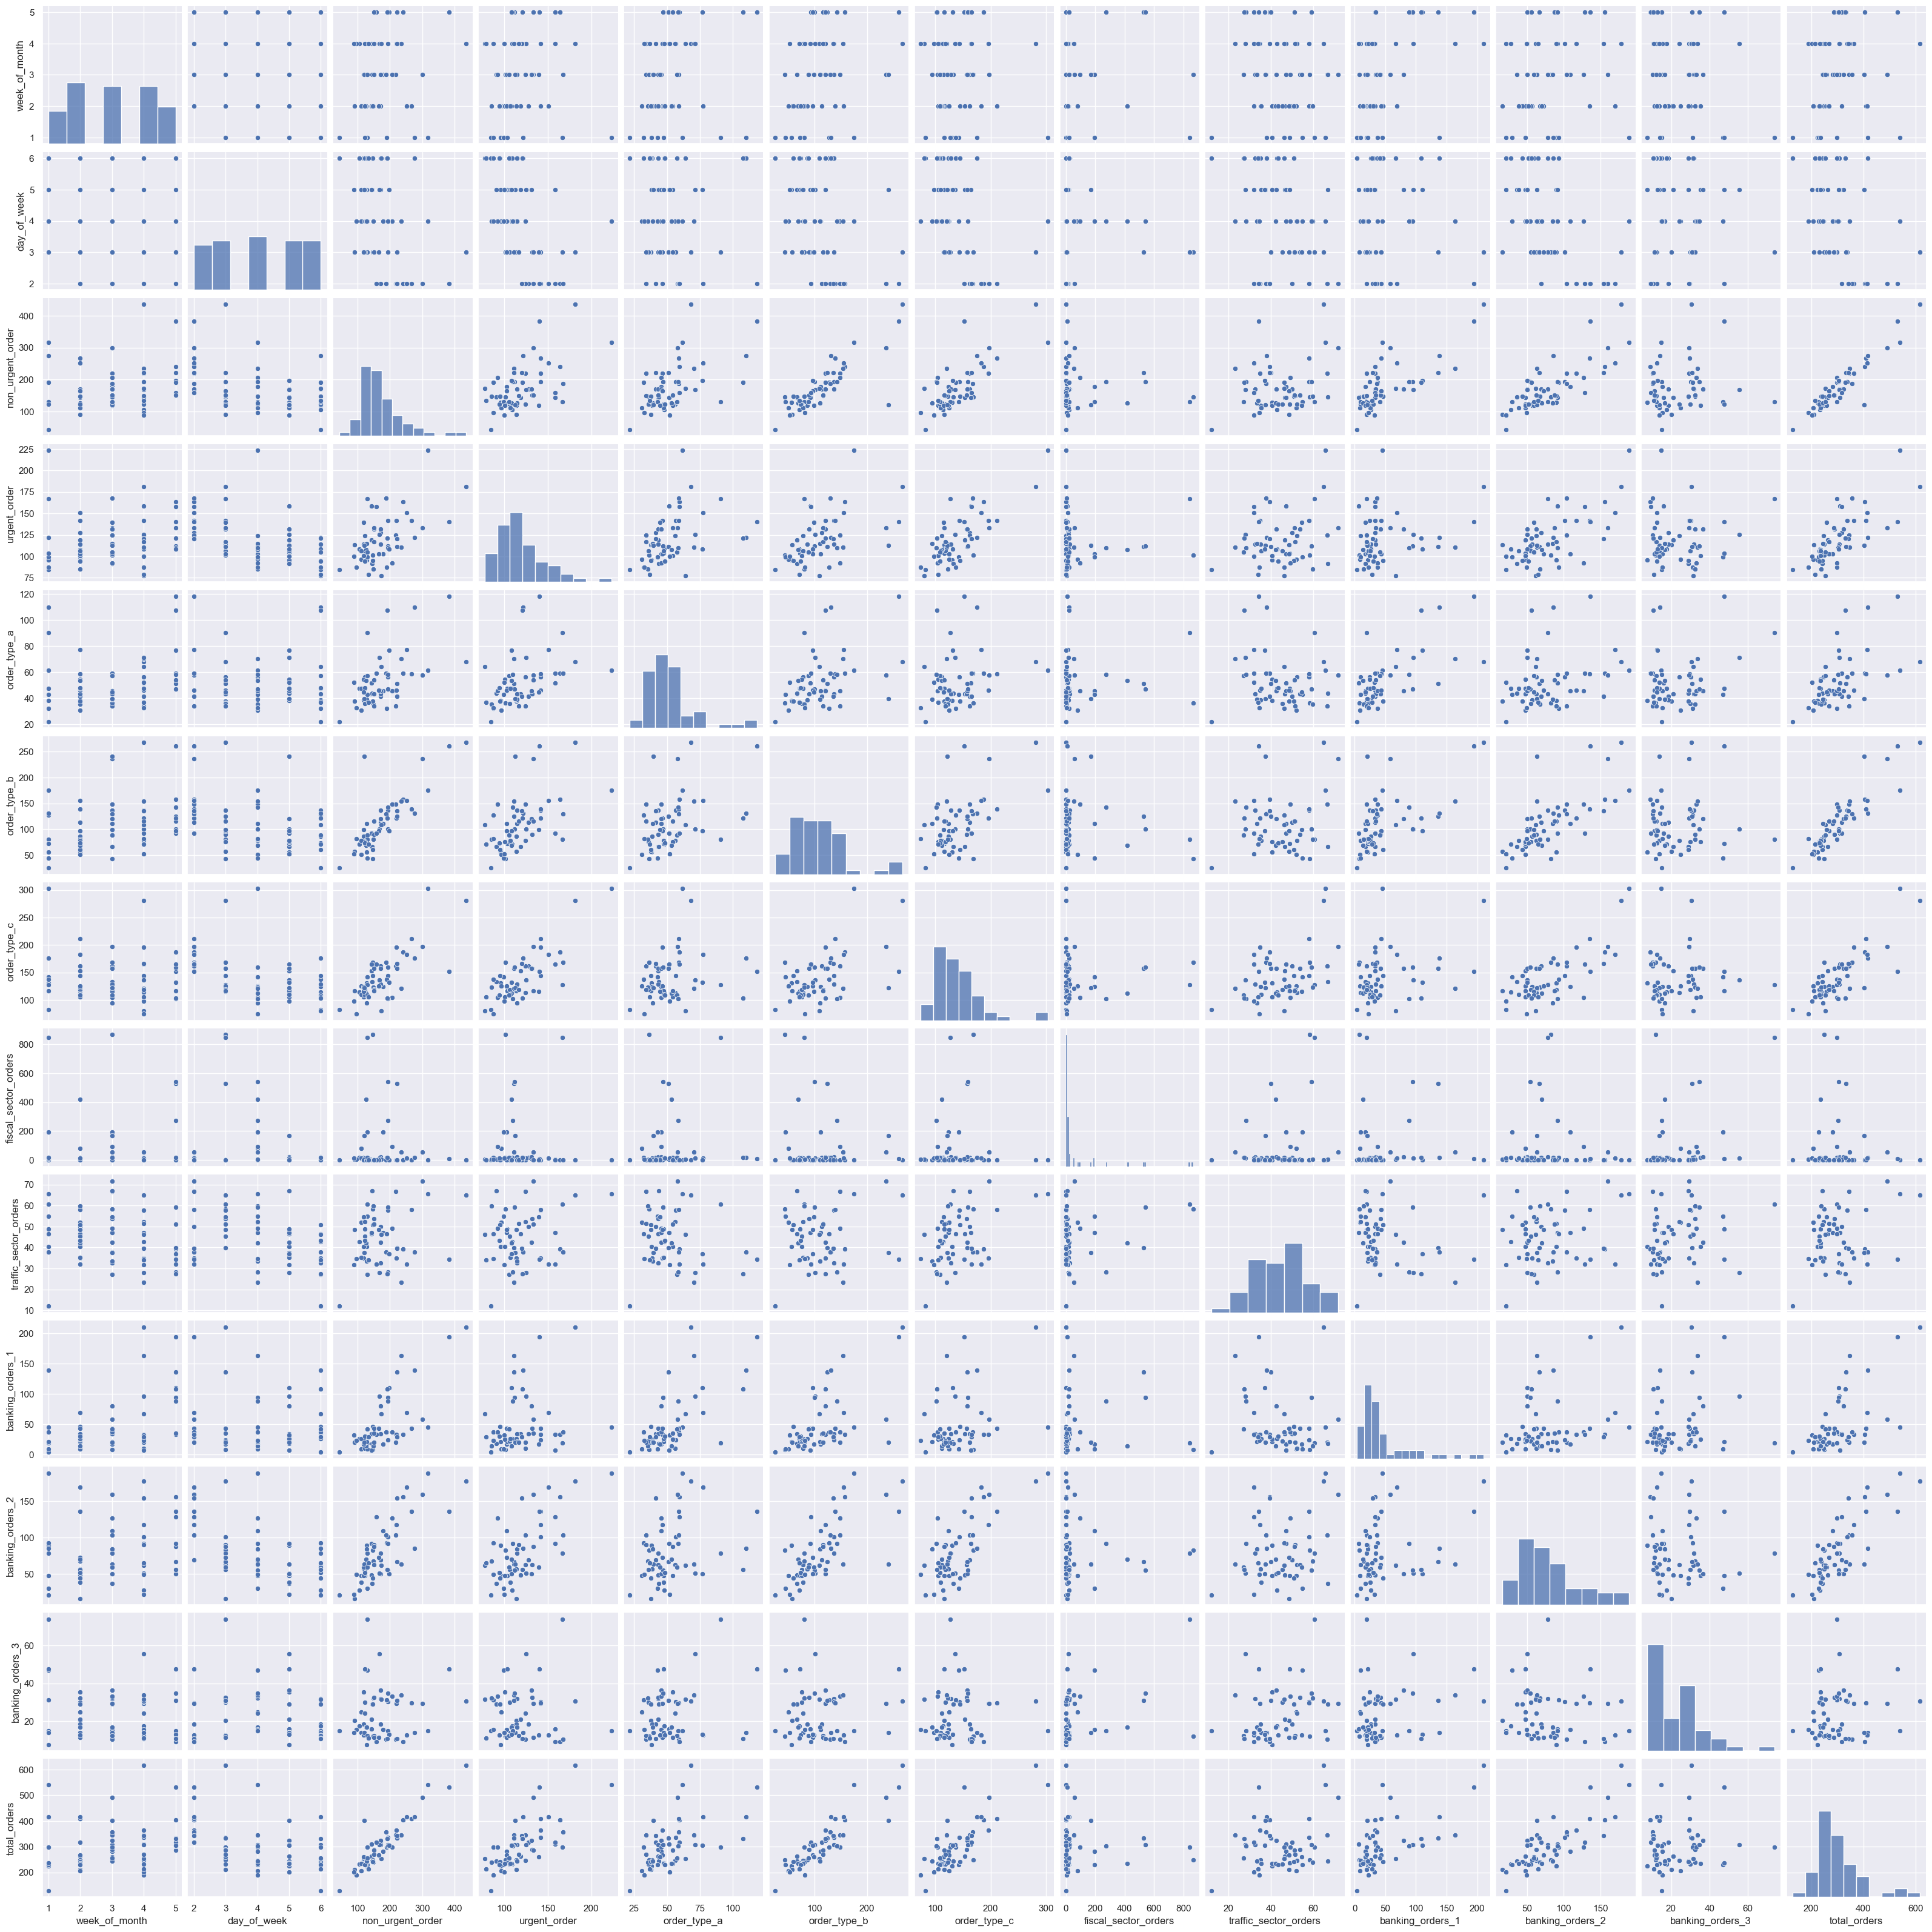

In [264]:
sns.pairplot(df) 

Further investigation of the pair plot reveals that there are several features that are highly correlated. In particular, order_type_b, order_type_c, and banking_orders_2 are all positively correlated with non-urgent_orders. order_type_c and urgent orders are positively correlated, and banking_orders_2 and non_urgent_orders are highly correlated. Referencing the correlation matrix, we can see that all of the afore-mentioned features have a correlation value of 0.8 or higher - so there is possible evidence of multicollinearity that should be considered during model creation. Additional EDA was performed on a subset of the features later in the notebook once I had selected relevant predictor variables. 

# Model Creation

## Simple Linear Regression
From the correlation matrix, we can estimate that the 'non_urgent_order' feature is the single best predictor variable. So for the first step I created a linear regression model using only that feature. 

The resulting R-squared value was 0.856 and the p-value of the non_urgent_orders feature indicated it was significant, which was surprisingly good for only using a single feature. 

In [289]:
X_train, X_test = train_test_split(df, test_size=0.2)

single_model = smf.ols(formula='total_orders ~ non_urgent_order', data = X_train).fit()
print(single_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     273.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           5.47e-21
Time:                        15:27:47   Log-Likelihood:                -236.44
No. Observations:                  48   AIC:                             476.9
Df Residuals:                      46   BIC:                             480.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           94.4455     13.216  

## Additional model evaluation - polynomial features
The simple linear regresion model performed better than anticipated but we really want to explore more complex models that use more features in order to get better predictions. The next model I evaluated was a polynomial regresion model using the 'non_urgent_order' feature. For my polynomial model I chose to only fit up to N=5 as I don't want the model to become overly complex, difficult to interpret, and overfit the training data. 

The adjusted R-squared did increase as polynomial features were added, but not by a large amount. Also, several of the polynomial features had p-values that indicated they were not statistically significnat, so I opted to move on from this model. 

In [268]:
formula = 'total_orders ~ non_urgent_order'
for n in range (2, 7):
    poly_model = smf.ols(formula=formula, data=X_train).fit()
    formula += f'+ np.power(non_urgent_order, {n})'
    print(poly_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     326.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.59e-22
Time:                        14:41:07   Log-Likelihood:                -237.10
No. Observations:                  48   AIC:                             478.2
Df Residuals:                      46   BIC:                             481.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           93.4875     12.691  

## Additional model evaluation - multi-linear regression
The next obvious step is to evaluate a multi-linear regression model that considers all available features. I started with every feature and performed backwards step-wise regression, removing a single feature with the highest p-value each iteration. 

In [269]:
X_train, X_test = train_test_split(df, test_size=0.2)

multi_model = smf.ols(formula='total_orders ~ week_of_month + day_of_week + non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + traffic_sector_orders + banking_orders_1 + \
                      banking_orders_2 + banking_orders_3', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.069e+28
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1261.8
No. Observations:                  48   AIC:                            -2498.
Df Residuals:                      35   BIC:                            -2473.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.137e-

In [270]:
multi_model = smf.ols(formula='total_orders ~ week_of_month + day_of_week + non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + traffic_sector_orders + banking_orders_1 + \
                      banking_orders_3', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.785e+29
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1329.5
No. Observations:                  48   AIC:                            -2635.
Df Residuals:                      36   BIC:                            -2613.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.137e-

In [271]:
multi_model = smf.ols(formula='total_orders ~ week_of_month + day_of_week + non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + traffic_sector_orders + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.974e+29
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1327.3
No. Observations:                  48   AIC:                            -2633.
Df Residuals:                      37   BIC:                            -2612.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.126e-

In [272]:
multi_model = smf.ols(formula='total_orders ~ week_of_month + day_of_week + non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.165e+29
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1308.9
No. Observations:                  48   AIC:                            -2598.
Df Residuals:                      38   BIC:                            -2579.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.137e-13 

In [273]:
multi_model = smf.ols(formula='total_orders ~ week_of_month + non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.547e+29
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1308.2
No. Observations:                  48   AIC:                            -2598.
Df Residuals:                      39   BIC:                            -2582.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.705e-13 

In [274]:
multi_model = smf.ols(formula='total_orders ~ non_urgent_order + \
                      urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.877e+30
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1344.4
No. Observations:                  48   AIC:                            -2673.
Df Residuals:                      40   BIC:                            -2658.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.132e-14 

In [275]:
multi_model = smf.ols(formula='total_orders ~ urgent_order + order_type_a + order_type_b + order_type_c + \
                      fiscal_sector_orders + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.193e+31
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1384.5
No. Observations:                  48   AIC:                            -2755.
Df Residuals:                      41   BIC:                            -2742.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.203e-13 

In [276]:
multi_model = smf.ols(formula='total_orders ~ urgent_order + order_type_a + \
                       order_type_b + order_type_c + banking_orders_1', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.367e+30
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1327.5
No. Observations:                  48   AIC:                            -2643.
Df Residuals:                      42   BIC:                            -2632.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         2.558e-13   1.71e-13  

In [277]:
multi_model = smf.ols(formula='total_orders ~ urgent_order + order_type_a + \
                       order_type_b + order_type_c', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.613e+30
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1337.2
No. Observations:                  48   AIC:                            -2664.
Df Residuals:                      43   BIC:                            -2655.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.395e-14   1.36e-13      0.470   

In [278]:
multi_model = smf.ols(formula='total_orders ~ order_type_a + \
                       order_type_b + order_type_c', data=X_train).fit()
print(multi_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.033e+30
Date:                Tue, 10 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:07   Log-Likelihood:                 1359.5
No. Observations:                  48   AIC:                            -2711.
Df Residuals:                      44   BIC:                            -2703.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.842e-14   7.17e-14     -0.396   

Eventually I arrived at the model above, which only uses order_type_a, order_type_b, and order_type_c as features. Looking back at the correlation matrix, non_urgent_order, order_type_b, and order_type_c were the features I would have anticipated to be the best predictors based on their correlation with total_sales. However, non_urgent_order is highly correlated with order_type_b and order_type_c, so perhaps the findings aren't too surprising and non_urgent_order is a proxy for order_type_b and order_type_c. However, the Adjusted R-squared value on the above model is 1, again an unrealistic value. 

### Forward stepwise model selection
I next performed forward stepwise regression to compare that model to the backwards stepwise model above. I only did this up to k=4 to approximately coincide with the number of feature in the final backwards stepwise model. 

## k=1

In [279]:
train_fwd, test_fwd = train_test_split(df, test_size=0.2)

feats = ['week_of_month', 'day_of_week', 'non_urgent_order', 'urgent_order', 'order_type_a',
       'order_type_b', 'order_type_c', 'fiscal_sector_orders', 'traffic_sector_orders',
       'banking_orders_1', 'banking_orders_2', 'banking_orders_3']
best = ['',0]
for p in feats:
    fwd_model  = smf.ols(formula='total_orders ~ ' + p, data=train_fwd).fit()
    print(p, fwd_model.rsquared)
    if fwd_model.rsquared>best[1]:
        best = [p, fwd_model.rsquared]
print('best:',best)

week_of_month 0.05470215657010469
day_of_week 0.18737224935781627
non_urgent_order 0.9376120164475983
urgent_order 0.591580939900129
order_type_a 0.41463967805617874
order_type_b 0.8375873936239477
order_type_c 0.7140521221860132
fiscal_sector_orders 0.005169176252025176
traffic_sector_orders 0.06045804972377733
banking_orders_1 0.46748638116004193
banking_orders_2 0.6417502335209877
banking_orders_3 0.02283653552927245
best: ['non_urgent_order', 0.9376120164475983]


## k = 2 

In [280]:
feats = ['week_of_month', 'day_of_week', 'urgent_order', 'order_type_a',
       'order_type_b', 'order_type_c', 'fiscal_sector_orders', 'traffic_sector_orders',
       'banking_orders_1', 'banking_orders_2', 'banking_orders_3']
best = ['',0]
for p in feats:
    fwd_model  = smf.ols(formula='total_orders ~ non_urgent_order +' + p, data=train_fwd).fit()
    print(p, fwd_model.rsquared)
    if fwd_model.rsquared>best[1]:
        best = [p, fwd_model.rsquared]
print('best:',best)

week_of_month 0.9391721668620914
day_of_week 0.9387272628941599
urgent_order 0.9936109661460667
order_type_a 0.9408476621648078
order_type_b 0.9400228818278423
order_type_c 0.9595610827766224
fiscal_sector_orders 0.9377250384080374
traffic_sector_orders 0.9388079996940496
banking_orders_1 0.9434061248236566
banking_orders_2 0.944221386144036
banking_orders_3 0.9382659084059867
best: ['urgent_order', 0.9936109661460667]


## k = 3

In [281]:
feats = ['week_of_month', 'day_of_week', 'order_type_a',
       'order_type_b', 'order_type_c', 'fiscal_sector_orders', 'traffic_sector_orders',
       'banking_orders_1', 'banking_orders_2', 'banking_orders_3']
best = ['',0]
for p in feats:
    fwd_model  = smf.ols(formula='total_orders ~ non_urgent_order + urgent_order +' + p, data=train_fwd).fit()
    print(p, fwd_model.rsquared)
    if fwd_model.rsquared>best[1]:
        best = [p, fwd_model.rsquared]
print('best:',best)

week_of_month 0.99378101975769
day_of_week 0.9947627046751834
order_type_a 0.9942911776597991
order_type_b 0.9939994654621609
order_type_c 0.9936609443689635
fiscal_sector_orders 0.9939077343095831
traffic_sector_orders 0.9941849899716633
banking_orders_1 0.9940157926754154
banking_orders_2 0.9943126357024673
banking_orders_3 0.9937476063149185
best: ['day_of_week', 0.9947627046751834]


## k = 4

In [282]:
feats = ['week_of_month', 'day_of_week', 'order_type_a',
       'order_type_c', 'fiscal_sector_orders', 'traffic_sector_orders',
       'banking_orders_1', 'banking_orders_2', 'banking_orders_3']
best = ['',0]
for p in feats:
    fwd_model  = smf.ols(formula='total_orders ~ non_urgent_order + urgent_order + \
                         order_type_b +' + p, data=train_fwd).fit()
    print(p, fwd_model.rsquared)
    if fwd_model.rsquared>best[1]:
        best = [p, fwd_model.rsquared]
print('best:',best)

week_of_month 0.9943772806704085
day_of_week 0.9953550296150288
order_type_a 0.9947335291104842
order_type_c 0.9941247886029474
fiscal_sector_orders 0.9941318001790852
traffic_sector_orders 0.9943780300318694
banking_orders_1 0.9943645848322714
banking_orders_2 0.9948147756741181
banking_orders_3 0.9940995244219916
best: ['day_of_week', 0.9953550296150288]


## Final forwards stepwise model
The final forwards stepwise model included non_urgent_order, urgent_order, order_type_b and order_type_c as features and had an Adj R-squared value of 0.994. I selected this model over the backwards stepwise model because the Adj R-Squared value of 1.0 is not realistic and likely indicates issues with that model. 

In [283]:
final_fwd = smf.ols(formula ='total_orders ~ non_urgent_order + urgent_order + \
                         order_type_b + order_type_c', data=train_fwd).fit()
print(final_fwd.summary())

                            OLS Regression Results                            
Dep. Variable:           total_orders   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     1819.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.42e-47
Time:                        14:41:07   Log-Likelihood:                -161.31
No. Observations:                  48   AIC:                             332.6
Df Residuals:                      43   BIC:                             342.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            9.0554      4.941  

The next thing I did was inspect the KDE of each of the four features in the final model to see their distribution. All four features had relatively normal distributions with spikes in the upper regions. However, there is nothing to lead me to believe that thoes spikes are incorrect data points, so I left them in the model. 

Text(0.5, 1.0, 'non_urgent_order kde')

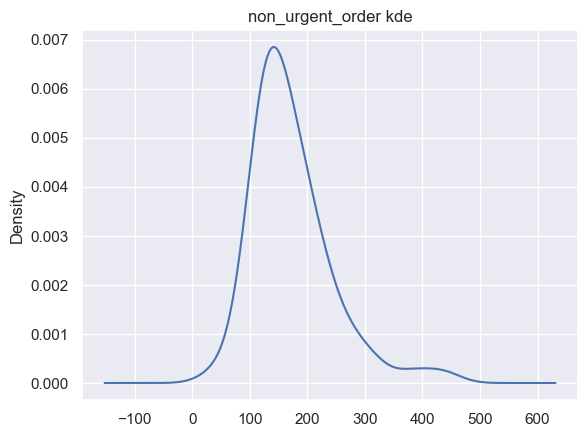

In [284]:
# Plot the kde of the final features. 
df.non_urgent_order.plot.kde()
plt.title("non_urgent_order kde")

Text(0.5, 1.0, 'urgent_order kde')

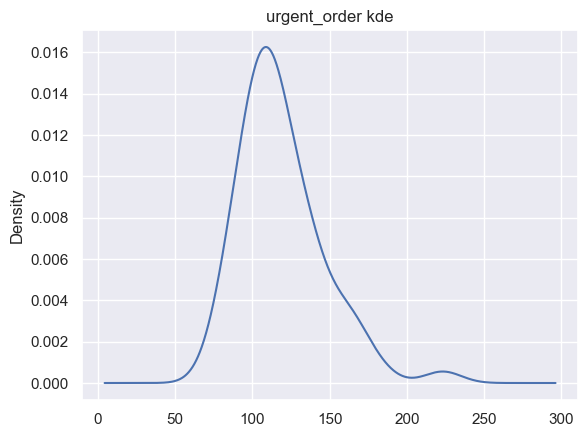

In [285]:
df.urgent_order.plot.kde()
plt.title("urgent_order kde")

Text(0.5, 1.0, 'order_type_b kde')

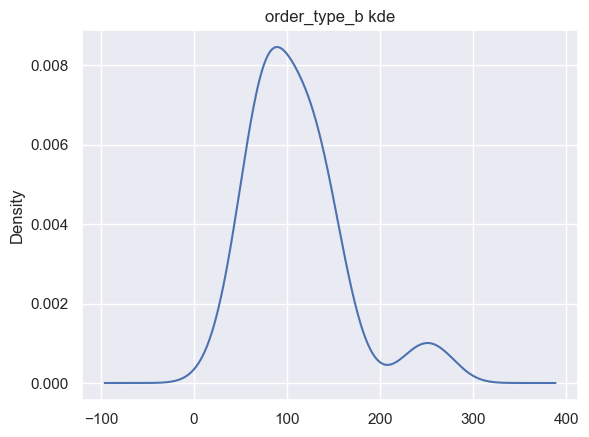

In [286]:
df.order_type_b.plot.kde()
plt.title("order_type_b kde")

Text(0.5, 1.0, 'order_type_c kde')

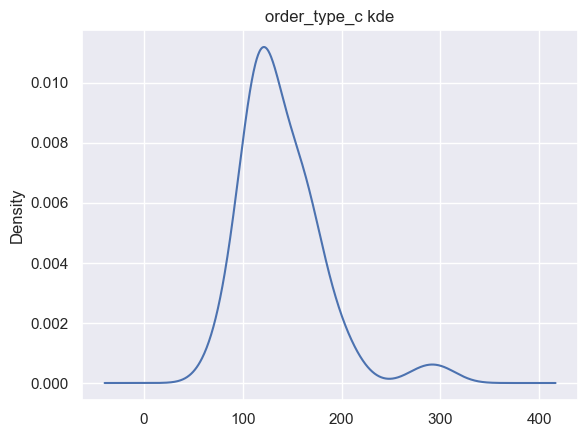

In [287]:
df.order_type_c.plot.kde()
plt.title("order_type_c kde")

The forward stepwise model evaluation technique worked best and resulted in a very good Adjusted R-squared value on the training data, so my next step was to plot the Adjusted R-squared values of the training and testing data vs. the number of predictors used in the forward stepwise model creation. 

Surprisingly, the Adjusted R-squared for the test data surpasses the Adjusted R-squared for the training data once the number of predictors gets to 3. For 3 and 4 predictors the Adjusted R-Squared is higher for the test data than the training data.

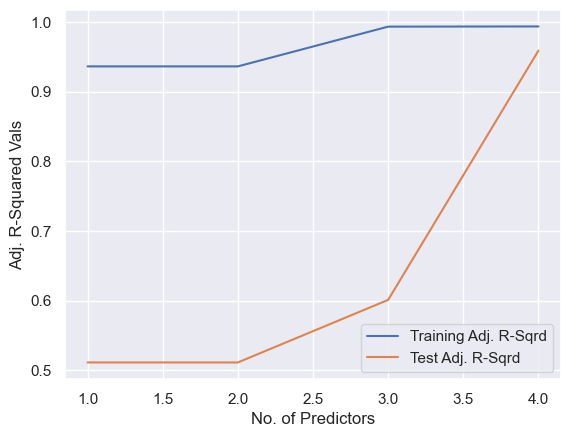

In [288]:
formula = 'total_orders'
adjr2_train = []
adjr2_test = []
fwd_feat = ['non_urgent_order', 'urgent_order', 'order_type_b', 'order_type_c']

for p in fwd_feat:
    if len(adjr2_train) == 0:
        formula += '~' + p
        fwd_train_model = smf.ols(formula=formula, data=train_fwd).fit()
        adjr2_train.append(fwd_train_model.rsquared_adj)
        fwd_test_model = smf.ols(formula=formula, data=test_fwd).fit()
        adjr2_test.append(fwd_test_model.rsquared_adj)
        formula += '+' + p
    else:
        fwd_train_model = smf.ols(formula=formula, data=train_fwd).fit()
        adjr2_train.append(fwd_train_model.rsquared_adj)
        fwd_test_model = smf.ols(formula=formula, data=test_fwd).fit()
        adjr2_test.append(fwd_test_model.rsquared_adj)
        formula += '+' + p
        
x = [1,2,3,4]
y1 = adjr2_train
y2 = adjr2_test

fix, ax = plt.subplots()
ax.plot(x, y1, label='Training Adj. R-Sqrd')
ax.plot(x, y2, label='Test Adj. R-Sqrd')
ax.legend()
ax.set_xlabel('No. of Predictors')
ax.set_ylabel('Adj. R-Squared Vals')
plt.show()
    

# Conclusion
Given the performance of the forward stepwise regression model, I opted to select that as my final model. I was very surprised to see that the model performed better on the test data than on the training data; I don’t recall seeing that before. It was interesting to learn that the forward stepwise and backwards stepwise processes can yield such different results. I was also surprised to see that the Adjusted R-squared value of the backwards stepwise model was 1.0, even when the number of predictor variables was slimmed down to only 4. 

The other takeaway I had from this project is that it would have been helpful if the Brazilian logistics company could have measured outside factors, or have a much larger sample size. It would be interesting to see how the total sales were impacted by things like the ecomony as a whole, the time of year, the weather, etc. 

A link to this project can be found here:
https://github.com/mattterry13/MS-DS